# STROJNO UČENJE - PROJEKT
## EDA Student Performance Dataset
### Predviđanje uspjeha učenika pomoću demografskih i socio-ekonomskih informacija

# Sadržaj
[Library Import](#Library-import)

[Vizualizacija podataka](#Vizualizacija-podataka)

- [Kategoričke varijable](#Kategoričke-značajke)

- [Numeričke varijable](#Numeričke-značajke)

- [Usporedba spola](#Usporedba-spola)


[Feature Selection](#Feature-selection-&-encoding)

[Modeli](#Modeli)
- [Priprema podataka](#Priprema-podataka)

    -[Label Encoding](#Label-encoding)
    
    -[Train-test Split](#Train-Test-Split)

- [Regresija](#Modeli-linearne-regresije)

    -[Linearna Regresija](#Linearna-regresija)
    
    -[Lasso](#MultitaskLasso-Regresija-(3-izlaza))
    
    -[Ridge](#Ridge-regresija)
   
- [Slučajne šume](#slučajne-šume)

# Library import

In [1]:
#%% Imports


#SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection 

import squarify
from sklearn.pipeline import Pipeline


# Basic Imports 
import numpy as np
import pandas as pd

# Plotting 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

# Preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder

# Metrics 
import sklearn.metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# ML Models
import lightgbm as lgb
from lightgbm import LGBMRegressor 
import xgboost as xg 
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.linear_model import LinearRegression, Ridge
# Model Tuning 
from bayes_opt import BayesianOptimization

# Feature Importance 
import shap

# Ignore Warnings 
import warnings
warnings.filterwarnings('ignore')



# Import dataseta

In [2]:
df = pd.read_csv('StudentsPerformance.csv')

df['AVERAGE'] = df[['math score', 'reading score','writing score']].mean(axis=1)

# Vizualizacija podataka

In [3]:

df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,AVERAGE
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


In [4]:
df.shape

(1000, 9)

## Kategoričke značajke

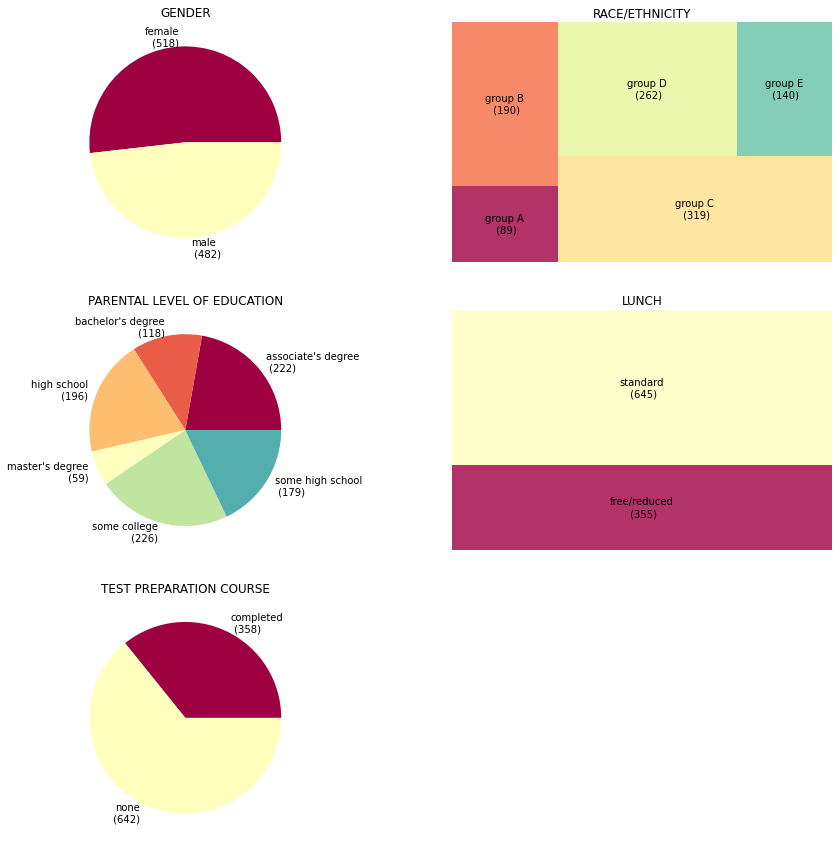

In [5]:
f, axes=plt.subplots(3, 2, figsize=(15, 15))
for i in range(5):
    plt.subplot(3, 2, i+1)
    
    df_grouped= df.groupby(df.columns[i]).size().reset_index(name='counts')
    labels = df_grouped.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
    sizes = df_grouped['counts'].values.tolist()
    colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]
    
    if i % 2 == 1:
       squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)
    else:
        plt.pie(sizes, labels=labels, colors=colors)
    plt.title(df.columns[i].upper())
    plt.axis('off')
    
plt.subplot(3, 2, 6)
plt.axis('off')
plt.show()

## Numeričke značajke 

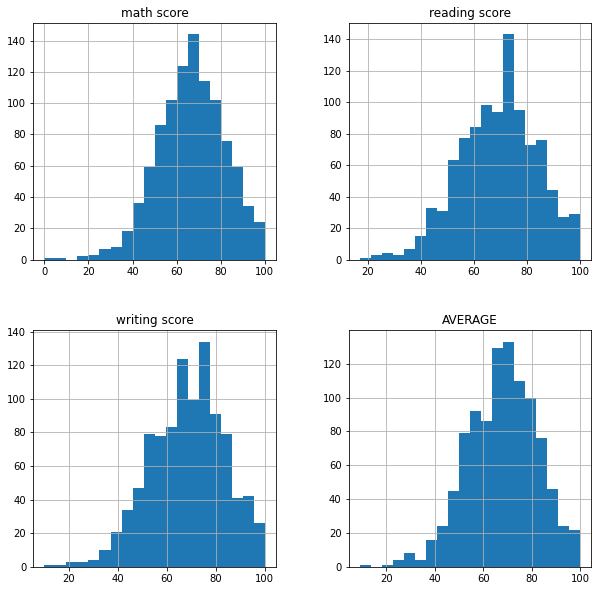

In [6]:
df.hist(figsize=(10,10),bins = 20)
plt.show()

## Usporedba spola

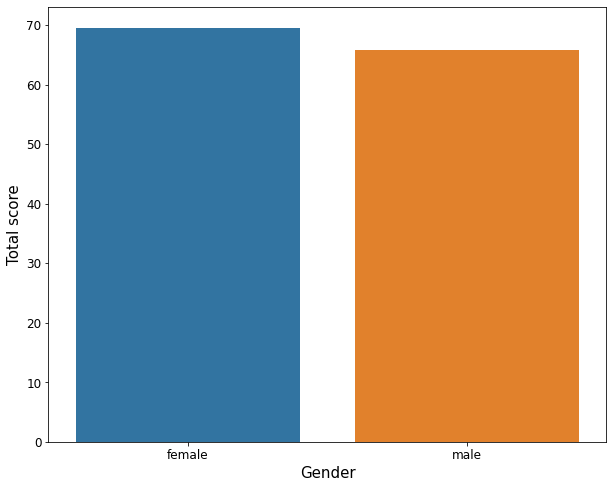

In [7]:
df['Total score'] = ((df['math score']+df['writing score']+df['reading score'])/3).round(2)
plt.figure(figsize = (10,8))
sns.barplot(data = df, x = 'gender', y = 'Total score', ci = False)
plt.xticks(fontsize = 12)
plt.xlabel('Gender', fontsize = 15)
plt.yticks(fontsize = 12)
plt.ylabel('Total score', fontsize = 15)
plt.show()

## Utjecaj priprema za ispit na rezultate 

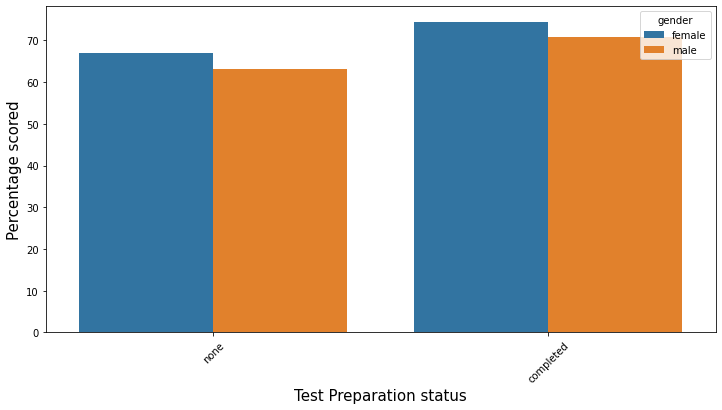

In [8]:
plt.figure(figsize = (12,6))
sns.barplot(data = df, x = 'test preparation course', y = 'Total score', hue = 'gender', ci = False)
plt.xlabel('Test Preparation status', fontsize = 15)
plt.xticks(rotation = 45)
plt.ylabel('Percentage scored', fontsize = 15)
plt.show()

# Feature selection & encoding

## Kodiranje atributa

Moramo napraviti preinake u našim podacima. Točnije, smetaju nam kategoričke varijable pošto algoritmi strojnog učenja ne rade sa kategoričkim varijablama. Postoji više pristupa tom problemu: 

    - One Hot Encoding (funkcija get_dummies)
    - Biblioteka LabelEncoder
    - Ručno, pomoću funkcije replace
    
Referenca: https://pbpython.com/categorical-encoding.html

In [9]:
# moramo napraviti label encoding
# pogledajmo prvo koje su nam vrijednosti u svakom stupcu
for col in df:
    if col == 'math score':
        break
    print(col, ' --> ', df[col].unique())

gender  -->  ['female' 'male']
race/ethnicity  -->  ['group B' 'group C' 'group A' 'group D' 'group E']
parental level of education  -->  ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
lunch  -->  ['standard' 'free/reduced']
test preparation course  -->  ['none' 'completed']


In [10]:
def find_and_replace(data):
    cleanup_nums = {
        'gender': { "female": 0, 'male': 1 },
        'race/ethnicity': { 'group A': 0, 'group B': 1, 'group C': 2, 'group D': 3, 'group E': 4 },
        'parental level of education': { 'some high school': 0, 'high school': 1,
                                        "associate's degree": 2, 'some college': 3,
                                        "bachelor's degree": 4, "master's degree": 5,  },
        'lunch': { 'standard': 0, 'free/reduced': 1 },
        'test preparation course': { 'none': 0, 'completed': 1 },
    }
    return df.replace(cleanup_nums)

#one hot encoding
def one_hot_encoding(data):
    # we rename first and last columns for scalability, so we dont have to change our code in multiple places
    return pd.get_dummies(df, columns=['gender', 'race/ethnicity', \
                                       'parental level of education', \
                                       'lunch', 'test preparation course'], \
                          drop_first=True) \
            .rename(columns={\
                             'gender_male' : 'gender',\
                             'test preparation course_none' : 'test preparation course'\
                            })

def encode_data(table_input,enc_type="ONEHOT",removeY=True):
    
    table= table_input.copy()
    #target= table["AVERAGE"]
    if removeY:
        table = table.drop(["math score","reading score","writing score","AVERAGE"],axis = 'columns') 
    
    
    if enc_type == "ONEHOT":
        table = table.apply(lambda x: x.astype('category')) 
        table = pd.get_dummies(table,drop_first= True)
        return table
        #return one_hot_encoding(table)
        
    elif enc_type == "LABEL":
        categorical_features = table.select_dtypes(['object','category']).columns.to_list()
        labelencoder = LabelEncoder()
        for i in categorical_features:
            table[i] = labelencoder.fit_transform(table[i])
            
        return table
    else:
        return find_and_replace(table)
    
#Kako koristiti:

#X_features_encoded = encode_data(SP_csv_clean,enc_type="ONE HOT")
#X_features_encoded

#X_features_encoded = encode_data(SP_csv_clean,enc_type="LABEL")
#X_features_encoded

## Feature selection

In [11]:
def odaberi(algorithm,k,train_X, train_y,yname="not given"):
    selector = feature_selection.SelectKBest(algorithm, k)
    selector.fit(train_X, train_y)
    scores = -np.log10(selector.pvalues_)
    indices = np.argsort(scores)[::-1] # Vrati indekse koji sortiraju polje (obratno)

    plt.figure(figsize=(7,5))
    plt.plot(range(train_X.shape[1]), scores[indices], 'o', color='gray')
    plt.title(f'Univarijantni odabir znacajki za najvaznijih {k_best} znacajki')
    plt.ylabel(f'log p-vrijednosti metode {yname}')
    plt.xlim([-1, train_X.shape[1]])
    plt.xticks(range(train_X.shape[1]), train_X.columns.values[indices], rotation=90)
    plt.vlines(k_best-0.5, 0, np.max(scores), color='red', linestyle='--')
    plt.grid(True,linestyle='--')
    plt.tight_layout()

    [ i.set_color("red") for i in plt.gca().get_xticklabels() if i.get_text()[:5] == 'noise' ]

    plt.show()

### 1.Odabir encodinga za feature selection : ONE HOT ENCODING

In [12]:
X_features_encoded = encode_data(df,enc_type="ONEHOT")
Y = df["AVERAGE"]
k_best = int(len(X_features_encoded.columns)*0.8) 

In [13]:
train_X_N, valid_X_N, train_y_N, valid_y_N = train_test_split(
    X_features_encoded, 
    Y, 
    test_size=0.2, 
    shuffle = True, 
    random_state=1
)

train_y_N=train_y_N.astype('int')


### Rezultat s metodom: f_regression

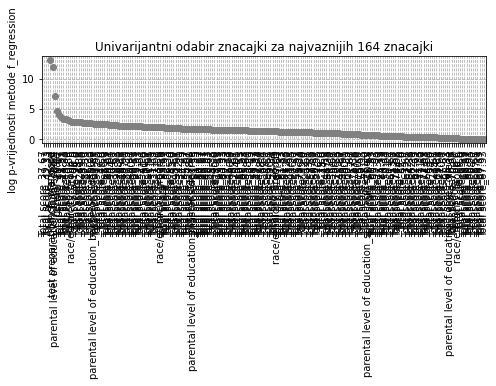

In [14]:
odaberi(feature_selection.f_regression,k_best,train_X_N, train_y_N,yname="f_regression")

### Rezultat s metodom: chi2

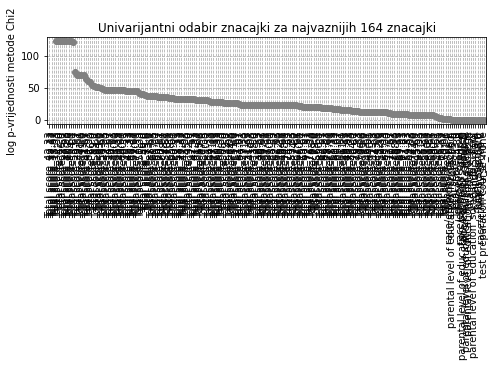

In [15]:
odaberi(feature_selection.chi2,k_best,train_X_N, train_y_N,yname="Chi2")

### 2.Odabir encodinga za feature selection : LABEL


In [16]:
X_features_encoded = encode_data(df,enc_type="LABEL")
Y = df["AVERAGE"]

k_best = int(len(X_features_encoded.columns)*0.8) 

In [17]:
train_X_N, valid_X_N, train_y_N, valid_y_N = train_test_split(
    X_features_encoded, 
    Y, 
    test_size=0.2, 
    shuffle = True, 
    random_state=1
)

train_y_N=train_y_N.astype('int')

### Rezultat s metodom: f_regression

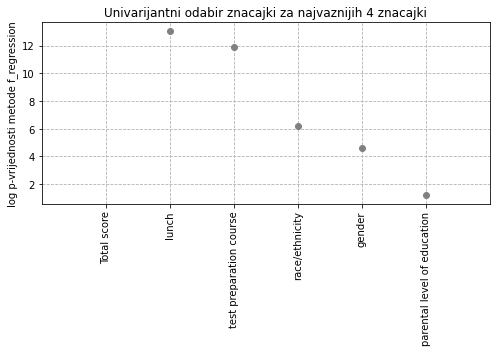

In [18]:
odaberi(feature_selection.f_regression,k_best,train_X_N, train_y_N,yname="f_regression")

### Rezultat s metodom: chi2

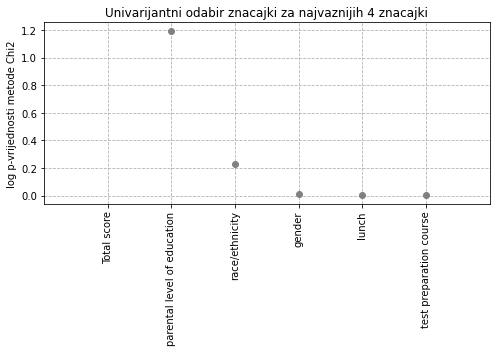

In [19]:
odaberi(feature_selection.chi2,k_best,train_X_N, train_y_N,yname="Chi2")

# Modeli

Na raspolaganju imamo puno različitih algoritama strojnog učenja koje možemo primjeniti na ovaj problem. Ideja je da prvo krenemo od jednostavnijih, pa nadograđujemo prema onim kompleksnijim modelima. 
Za početak ćemo iskoristiti sljedeće algoritme:
        
        - Algoritmi regresije
        - Support vector machines (SVM)
        - Slučajne šume

## Priprema podataka

### Funkcije za ispis grešaka

In [20]:
def residual(true,pred):
    resid = true - pred
    print( np.sqrt(np.mean(resid*resid)) )
def evaluateRegressor(true,predicted,message = "Test set"):
    MSE = mean_squared_error(true,predicted,squared = True)
    MAE = mean_absolute_error(true,predicted)
    RMSE = mean_squared_error(true,predicted,squared = False)
    R_squared = r2_score(true,predicted)
    print(message)
    print("MSE:", MSE)
    print("MAE:", MAE)
    print("RMSE:", RMSE)
    print(f"R-squared: {R_squared} , from <0,1> ")

### Train Test Split
Pošto nemamo unaprijed zadane trening i test podatke, uobičajeno je podijeliti cijelu našu bazu u dio za trening i dio za test. Najčešće se koristi sklearn funkcija train_test_split koja prima postotak podataka koji želimo da bude testni. U našem slučaju stavit ćemo 20% (800 trening, 200 test podataka).

In [21]:
X_features_encoded = encode_data(df,enc_type="LABEL")
Y = df["AVERAGE"]

train_X, valid_X, train_y, valid_y = train_test_split(
    X_features_encoded, 
    Y, 
    test_size=0.2, 
    shuffle = True, 
    #random_state=1
)

#train_y_N=train_y_N.astype('int')

In [22]:
df2 = one_hot_encoding(df)
train, test = train_test_split(df2, test_size=0.2)
features = train.loc[:, 'gender' : 'test preparation course']
targets = train.loc[:, 'math score' : 'Total score']

Ako ce nam trebat skalirani podaci ,tu su

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_X_scaled = scaler.fit_transform(train_X)
valid_X_scaled = scaler.transform(valid_X)

## Modeli linearne regresije

Osnovni algoritam regresije (a i cijele teorije strojnog učenja) je linearna regresija. Osim nje, postoje i neke modifikacije. Svaka ima svoje prednosti i mane, zbog kojih se sve koriste u određenim situacijama. Mi ćemo iskoristiti Lasso i Ridge, te usporediti rezultate svih.

### Linearna Regresija

In [24]:
model = Pipeline([ ('linear', LinearRegression()) ])
model = model.fit(features, targets)

regr_pred = model.predict(test.loc[:, 'gender' : 'test preparation course'])
#print(regr_pred)

correct_scores = test.loc[:, 'math score' : 'Total score']
explained_variance = explained_variance_score(correct_scores, regr_pred)
R2 = r2_score(correct_scores, regr_pred)
MSE = mean_squared_error(correct_scores, regr_pred)

print('Objasnjena varijanca = '+'{0:.2f}'.format(explained_variance)+'\nR2 = '+'{0:.2f}'.format(R2)+'\nMSE = '+'{0:.2f}'.format(MSE))

Objasnjena varijanca = 0.25
R2 = 0.24
MSE = 185.19


In [25]:
def lin_reg(X,y):
    LinearReg = LinearRegression(normalize = True)
    LinearReg = LinearReg.fit(X,y)

    return LinearReg


In [26]:
model_LINEAR = lin_reg(train_X,train_y)

predicted_valid_y = model_LINEAR.predict(valid_X)

In [27]:
residual(valid_y, predicted_valid_y)
evaluateRegressor(valid_y, predicted_valid_y)

0.002666120585167086
Test set
MSE: 7.108198974651685e-06
MAE: 0.002188249323261111
RMSE: 0.002666120585167086
R-squared: 0.9999999550803231 , from <0,1> 


### MultitaskLasso Regresija (3 izlaza)

In [28]:
X_lasso =df.drop(["math score","reading score","writing score","AVERAGE"],axis = 'columns') 
Y_3_lasso =df[["math score","reading score","writing score"]]

X_lasso = encode_data(X_lasso,enc_type="LABEL",removeY=False)

In [29]:
train_X_lasso, valid_X_lasso, train_y_lasso, valid_y_lasso = train_test_split(
    X_lasso, 
    Y_3_lasso, 
    test_size=0.2, 
    shuffle = True, 
    #random_state=1
)

In [30]:
# import linear model library
from sklearn import linear_model
  
# create MultiTaskLasso model
MTL = linear_model.MultiTaskLasso(alpha = 0.5)

# fit the model to a data
#MTL.fit([[1, 0], [1, 3], [2, 2]], [[0, 2], [1, 4], [2, 4]])
MTL.fit(train_X_lasso,train_y_lasso)

pred=MTL.predict(valid_X_lasso)
# perform prediction and print the result
#print("Prediciton result: \n", MTL.predict(valid_X_lasso), "\n")
  
# print the coefficients
#print("Coefficients: \n", MTL.coef_, "\n")
  
# print the intercepts
#print("Intercepts: \n", MTL.intercept_, "\n")
  
# print the number of iterations performed
#print("Number of Iterations: ", MTL.n_iter_, "\n")

In [31]:
residual(valid_y_lasso, pred)

print("\nScores:")
evaluateRegressor(valid_y_lasso, pred)

math score       4.095493
reading score    3.070505
writing score    2.831136
dtype: float64

Scores:
Test set
MSE: 11.405465227740669
MAE: 2.6679971497690507
RMSE: 3.3323780229057385
R-squared: 0.9472557094752269 , from <0,1> 


## Ridge regresija

Objasnjena varijanca = 0.25
R2 = 0.24
MSE = 185.22


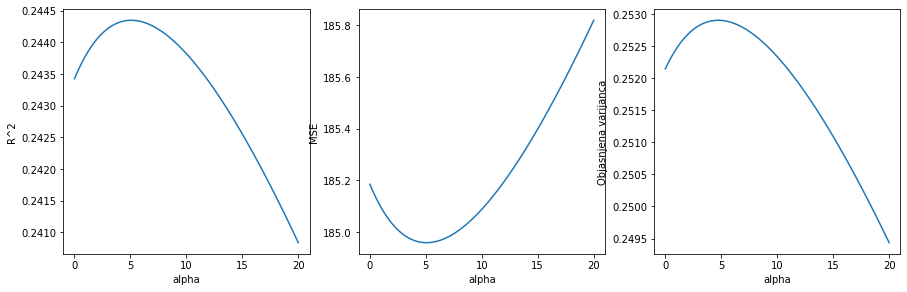

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))
alpha_array = np.linspace(0.01, 20.0, 100)
R2 = []
MSE = []
explained_variance = []

for alpha in alpha_array:
    model_ridge = Pipeline( [ ('ridge', Ridge(alpha=alpha)) ] )
    model_ridge = model_ridge.fit(features, targets)
    #R2_ridge = model_ridge.score(test.loc[:, 'gender' : 'test preparation course'], correct_scores)
    regr_pred = model_ridge.predict(test.loc[:, 'gender' : 'test preparation course'])
    explained_variance.append(explained_variance_score(correct_scores, regr_pred))
    R2.append(r2_score(correct_scores, regr_pred))
    MSE.append(mean_squared_error(correct_scores, regr_pred))

def avg(arr):
    return sum(arr) / len(arr)

print('Objasnjena varijanca = '+'{0:.2f}'.format(avg(explained_variance))+'\nR2 = '+'{0:.2f}'.format(avg(R2))+'\nMSE = '+'{0:.2f}'.format(avg(MSE)))
ax[0].plot(alpha_array, R2)
ax[0].set(xlabel='alpha', ylabel='R^2')
ax[1].plot(alpha_array, MSE)
ax[1].set(xlabel='alpha', ylabel='MSE')
ax[2].plot(alpha_array, explained_variance)
ax[2].set(xlabel='alpha', ylabel='Objasnjena varijanca')

plt.show()

## XGBoost

## LightGBM

In [33]:
LGBMReg = lgb.LGBMRegressor(random_state=0).fit(train_X,train_y)

predicted_train_y = LGBMReg.predict(train_X)
evaluateRegressor(train_y,predicted_train_y,"    Training Set")
predicted_valid_y = LGBMReg.predict(valid_X)
evaluateRegressor(valid_y,predicted_valid_y,"    Test Set")

    Training Set
MSE: 1.179773743007076
MAE: 0.20924466492478686
RMSE: 1.08617390090495
R-squared: 0.9944940316605794 , from <0,1> 
    Test Set
MSE: 0.0954502221182781
MAE: 0.10071032116262078
RMSE: 0.30895019358834863
R-squared: 0.9993968101974442 , from <0,1> 


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

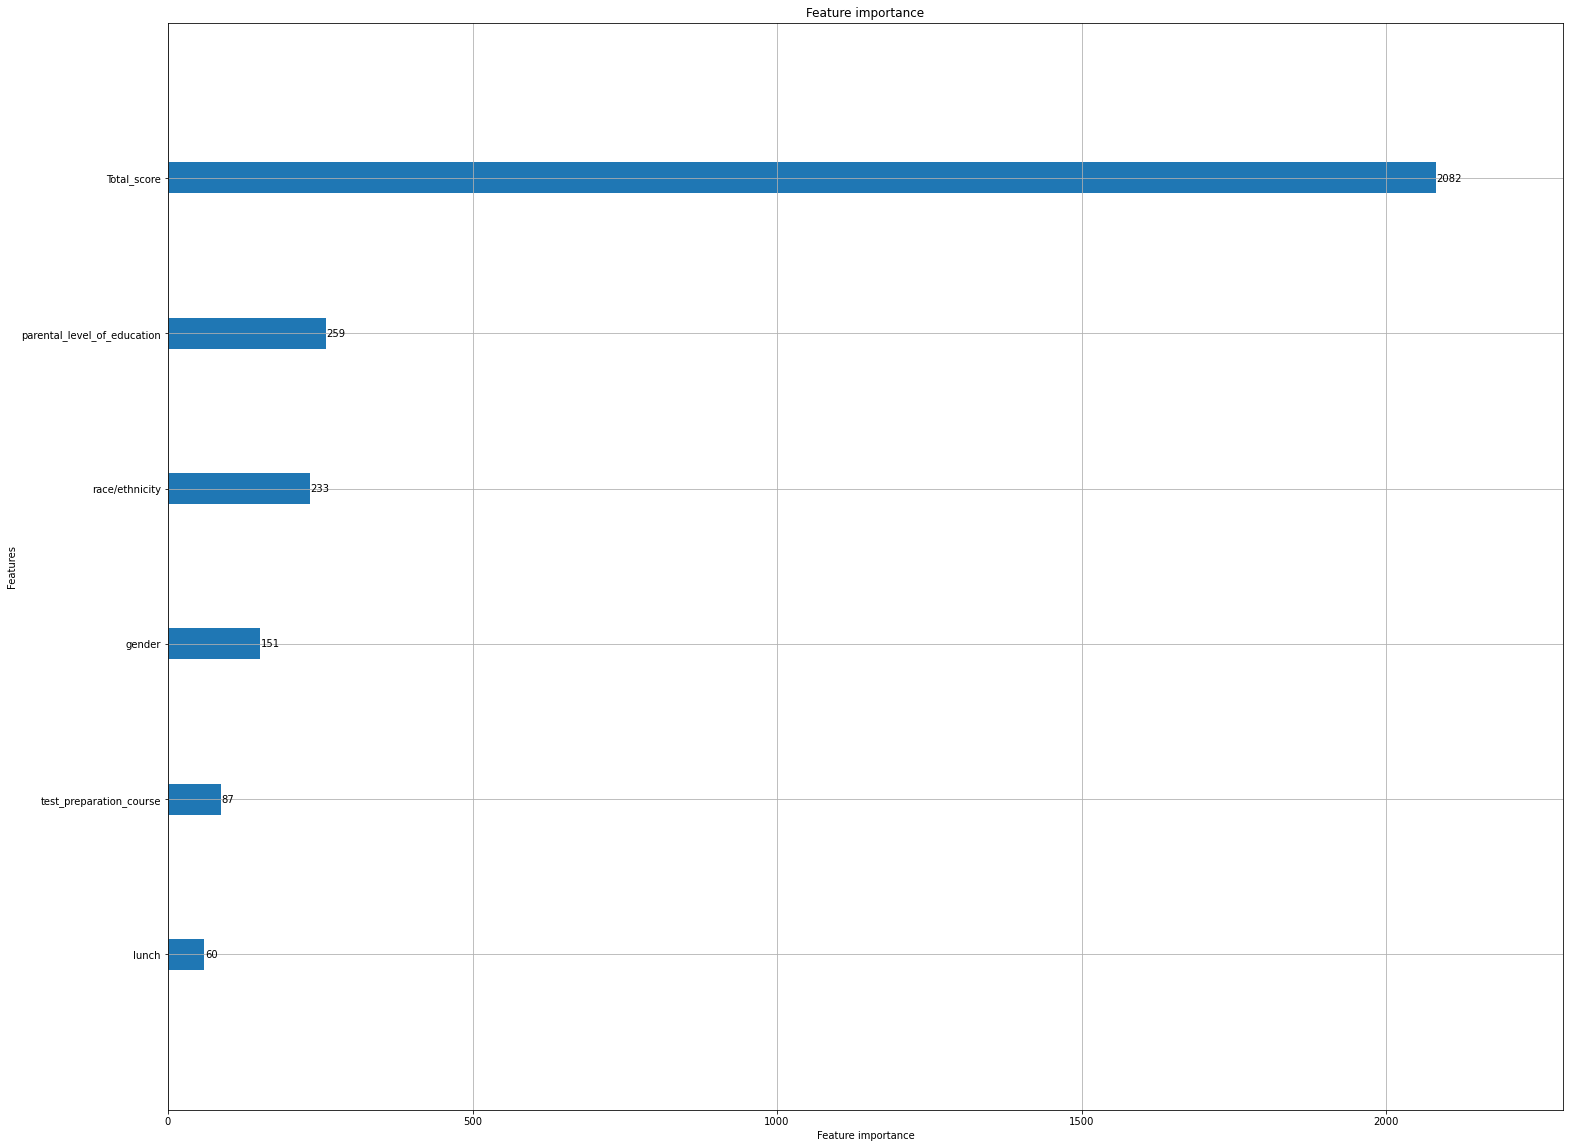

In [34]:
lgb.plot_importance(LGBMReg,figsize=(25,20))

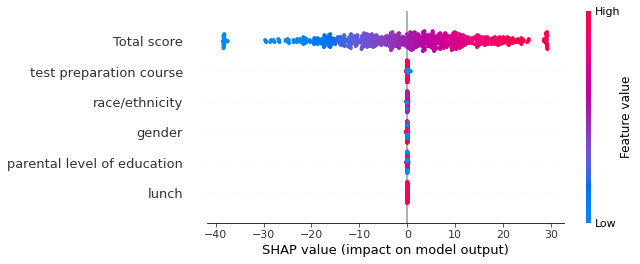

In [35]:
#LGBMReg.params['objective'] = 'regression'
shap_values = shap.TreeExplainer(LGBMReg).shap_values(train_X)
shap.summary_plot(shap_values, train_X)

## CATBoost

In [36]:
from catboost import CatBoostRegressor
# Initialize data

train_data = train_X

eval_data = valid_X

train_labels = train_y

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=200,
                          learning_rate=1,
                          depth=2)
# Fit model
model.fit(train_data, train_labels)


0:	learn: 6.9092968	total: 47.1ms	remaining: 9.36s
1:	learn: 5.3064786	total: 47.4ms	remaining: 4.69s
2:	learn: 4.6420501	total: 47.6ms	remaining: 3.13s
3:	learn: 4.2167891	total: 47.8ms	remaining: 2.34s
4:	learn: 3.7584000	total: 48ms	remaining: 1.87s
5:	learn: 3.5977234	total: 48.2ms	remaining: 1.56s
6:	learn: 3.3461976	total: 48.5ms	remaining: 1.34s
7:	learn: 3.2000655	total: 48.8ms	remaining: 1.17s
8:	learn: 2.9569118	total: 49.1ms	remaining: 1.04s
9:	learn: 2.4949015	total: 49.4ms	remaining: 939ms
10:	learn: 2.2649371	total: 49.7ms	remaining: 854ms
11:	learn: 1.9788831	total: 50ms	remaining: 783ms
12:	learn: 1.8726130	total: 50.2ms	remaining: 722ms
13:	learn: 1.7682282	total: 50.4ms	remaining: 670ms
14:	learn: 1.6741698	total: 50.7ms	remaining: 625ms
15:	learn: 1.6130867	total: 51ms	remaining: 586ms
16:	learn: 1.5577033	total: 51.3ms	remaining: 552ms
17:	learn: 1.5415205	total: 51.5ms	remaining: 521ms
18:	learn: 1.4943994	total: 51.8ms	remaining: 493ms
19:	learn: 1.4591803	total: 

In [37]:
# Get predictions
pred_train= model.predict(train_data)
pred = model.predict(eval_data)

In [38]:
residual(valid_y, pred)

print("\nScores:")
evaluateRegressor(train_y, pred_train)
evaluateRegressor(valid_y, pred)

0.19941814453767745

Scores:
Test set
MSE: 0.02126549621711101
MAE: 0.1106833525771099
RMSE: 0.14582693927087345
R-squared: 0.9999007545729954 , from <0,1> 
Test set
MSE: 0.03976759637085001
MAE: 0.14687526122131486
RMSE: 0.19941814453767745
R-squared: 0.9997486919561767 , from <0,1> 


## ANN

In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# Importing necessary models for implementation of ANN



model = Sequential()
model.add(Dense(100, input_dim=train_X.columns.value_counts().sum(), activation="softmax"))
model.add(Dense(100, activation="relu"))
model.add(Dense(1, kernel_initializer="normal"))
model.compile(loss="mean_squared_error", optimizer = "adam", metrics = ["mse"])

model.fit(train_X, train_y, epochs=300)

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
from tensorflow.keras.models import Model, load_model
#model.save('cnn_model.h5')
model = load_model('cnn_model.h5')

predicted_valid_y = model.predict(valid_X)
predicted_valid_y = pd.Series([i[0] for i in predicted_valid_y])

In [ ]:
residual(valid_y, predicted_valid_y)
evaluateRegressor(valid_y, predicted_valid_y)

## Slučajne šume

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Creating Random Forest Model
rf = RandomForestRegressor(n_estimators=400)

# Training Model
rf.fit(train_X , train_y)

In [ ]:
# Predictions
predictions = rf.predict(valid_X)

In [ ]:
residual(valid_y, predictions)
evaluateRegressor(valid_y, predictions)

## SVM

In [ ]:
SVM = svm.SVR().fit(train_X, train_y) 

In [ ]:
predicted_train_y = SVM.predict(train_X)                           #<----SVM -- Support Vector Machine
evaluateRegressor(train_y,predicted_train_y,"    Training Set")
predicted_valid_y = SVM.predict(valid_X)
evaluateRegressor(valid_y,predicted_valid_y,"    Test Set")

In [ ]:
from sklearn.svm import SVR
def SV_reg(kernel,train_X, train_Y):
    model=SVR(kernel)
    model.fit(train_X, train_Y)
    return model


SVM_model= SV_reg("linear",train_X, train_y)
pred_linear = SVM_model.predict(valid_X)
linear_rmse = np.sqrt(mean_squared_error(valid_y,pred_linear))

SVM_model= SV_reg("poly",train_X, train_y)
pred_poly = SVM_model.predict(valid_X)
poly_rmse = np.sqrt(mean_squared_error(valid_y,pred_poly))

SVM_model= SV_reg("sigmoid",train_X, train_y)
pred_sigmoid = SVM_model.predict(valid_X)
sigmoid_rmse = np.sqrt(mean_squared_error(valid_y,pred_sigmoid))

SVM_model= SV_reg("rbf",train_X, train_y)
pred_rbf = SVM_model.predict(valid_X)
rbf_rmse = np.sqrt(mean_squared_error(valid_y,pred_rbf))



data = {"kernel":pd.Series(["linear","polynomial","sigmoid","rbf"]),
            "Test RMSE":pd.Series([linear_rmse,poly_rmse,sigmoid_rmse,rbf_rmse]),
            "Pred":pd.Series([pred_linear,pred_poly,pred_sigmoid,pred_rbf])}
table_rmse=pd.DataFrame(data)
table_rmse

Grid search

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

K = 15
parameters = [{'kernel': ['linear','sigmoid','rbf'], 'gamma': [2e-3,2e-2, 2e-1, 1, 2, 4, 8, 16],'C': [2e-5,2e-4,2e-3,2e-2, 2e-1, 1, 2, 4, 8, 16]}]
scorer = make_scorer(mean_squared_error, greater_is_better=False)
svr_gs = GridSearchCV(SVR(epsilon = 0.01), parameters, cv = K, scoring=scorer)

svr_gs.fit(train_X, train_y)
print(svr_gs.best_params_)

ONCE WE GET BEST RESULTS , WE ONCE AGAIN TRAIN OUR MODEL Results:

{'C': 2, 'gamma': 0.002, 'kernel': 'linear'}

In [ ]:
regressor = SVR(**svr_gs.best_params_)
regressor.fit(train_X,train_y)
pred=regressor.predict(valid_X)

error = np.sqrt(mean_squared_error(valid_y,pred))
data = {"kernel":pd.Series(["GS Output"]),"Test RMSE":pd.Series([error]),"Pred":pd.Series([pred])}
table_rmse = table_rmse.append(pd.DataFrame(data))
print(table_rmse)

In [ ]:
svr_test_rmse = table_rmse["Test RMSE"].min()
print("Test RMSE using SVR is:",svr_test_rmse)

# Rezultati